In [3]:
import pickle
import numpy as np
from functions import *

# Load data
dataset_index = 1
data_mapped = pickle.load(open(f'cleaned_data/data_{dataset_index}.pkl', "rb"))
num_pedestrians = data_mapped['id'].nunique()
circumference = 2*np.pi*3 + 4 * 2

c:\Users\yutin\OneDrive - TU Eindhoven\University\School\Year 3\Q3\Bachelor Final Project Mathematics\data\functions.py:52: SyntaxWarning: invalid escape sequence '\s'
  """


In [4]:
# Format real data

pedestrian_ids = data_mapped['id'].unique()
num_frames = data_mapped['frame'].nunique()

# Map pedestrian ids to row indices
id_to_index = {pid: i for i, pid in enumerate(pedestrian_ids)}

real_positions = np.full((num_pedestrians, num_frames), np.nan)
for _, row in data_mapped.iterrows():
    pid_index = id_to_index[row['id']]
    frame_index = int(row['frame']) - 1
    real_positions[pid_index, frame_index] = row['position']

In [ ]:
def second_order_pedestrian_ode(t, y, c, s, tau_acc, tau_dec):
    """
    Second-order pedestrian model:
    y = [x_0, ..., x_n, u_0, ..., u_n]  (positions + velocities)
    """
    # Default circumference
    circumference = 2*np.pi*3 + 4 * 2

    n = len(y) // 2  # Number of pedestrians
    x = y[:n]  # Positions
    u = y[n:]  # Velocities

    dxdt = u  # dx/dt = velocity
    dudt = np.zeros(n)  # Initialize acceleration
    
    for i in range(n): 
        next_index = (i + 1) % n  # Wrap around for circular track
        gap = (x[next_index] - x[i]) % circumference  # Circular gap
        
        desired = c * max(0.0, 1 - s / gap)
        # Calculate desired velocity based on gap and speed limit
        tau = tau_acc if desired > u[i] else tau_dec
        dudt[i] = (desired - u[i]) / tau

        # if gap > s:
        #     desired_velocity = c * (1 - s / gap)
        #     dudt[i] = (desired_velocity - u[i]) / tau
        # else:
        #     dudt[i] = -u[i] / tau  # slow down to stop

        
    return np.concatenate([dxdt, dudt])  # Return both position and velocity derivatives

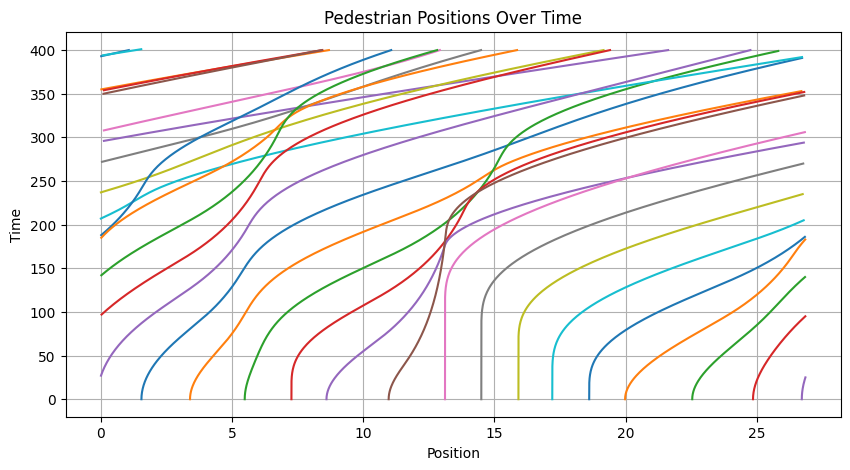

In [40]:
# visualize the second order pedestrian model
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ode params
c_value = 0.26179601  
s_value = 1.42100106 
tau_acc = 88.99285164 
tau_dec = 76.16709377

# Initial positions
initial_positions = data_mapped.groupby('id')['position'].first().values
initial_positions = np.sort(initial_positions)

# Initial velocities (zero for all pedestrians)
initial_velocities = np.zeros(num_pedestrians)

initial_conditions = np.concatenate([initial_positions, initial_velocities])

t_span = (0, num_frames - 1)
t_eval = np.arange(num_frames)

# Solve the ivp
sol = solve_ivp(
    second_order_pedestrian_ode,
    t_span,
    initial_conditions,
    args=(c_value, s_value, tau_acc, tau_dec),
    t_eval=t_eval
)

# Extract positions from the solution
simulated_positions = sol.y[:num_pedestrians, :] % circumference
simulated_velocities = sol.y[num_pedestrians:, :]

# Plot pedestrian positions over time
plt.figure(figsize=(10, 5))
for i in range(num_pedestrians):

    position_list = reset_laps(simulated_positions[i, :].tolist())
    
    new_frame_list = list(range(len(position_list)))
    plt.plot(position_list, new_frame_list, label=f'Person {i+1}')

plt.title('Pedestrian Positions Over Time')
plt.ylabel('Time')
plt.xlabel('Position')
plt.grid(True)
plt.show()


### Compare with original data

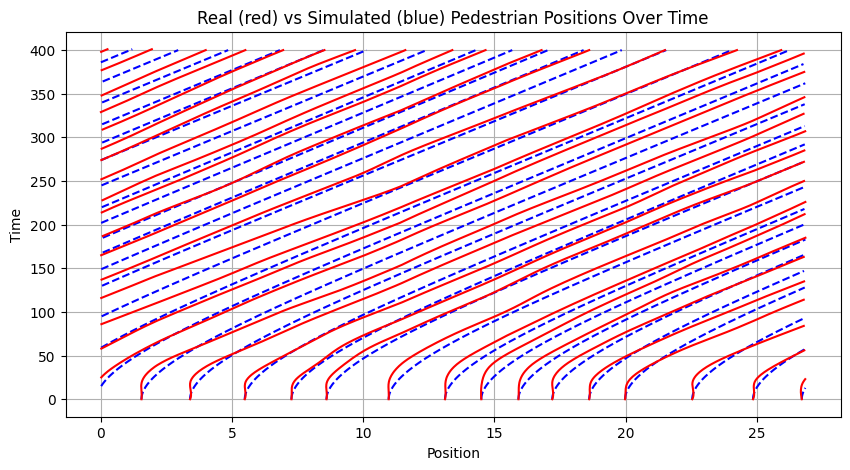

In [30]:
plt.figure(figsize=(10, 5))
# Plot simulated positions
for i in range(num_pedestrians):

    position_list = reset_laps(simulated_positions[i, :].tolist())
    
    new_frame_list = list(range(len(position_list)))
    plt.plot(position_list, new_frame_list, color='blue', linestyle='--')   


# Plot real positions
for person_id, person_data in data_mapped.groupby('id'):
    position_list = reset_laps(person_data['position'].tolist())
    new_frame_list = list(range(len(position_list)))
    plt.plot(position_list, new_frame_list, color='red')



plt.title('Real (red) vs Simulated (blue) Pedestrian Positions Over Time')
plt.ylabel('Time')
plt.xlabel('Position')
plt.grid(True)
plt.show()

### CBX

In [31]:
def compute_predicted_positions(params, t_eval):
    # Solve ODE
    c_value = params[0]
    s_value = params[1]
    tau_acc = params[2]
    tau_dec = params[3]
    sol = solve_ivp(
        second_order_pedestrian_ode,
        (0, t_eval[-1]),
        initial_conditions,
        args=(c_value, s_value, tau_acc, tau_dec),
        t_eval=t_eval
    )
    return sol.y[:num_pedestrians, :] % circumference  # Return only positions

In [35]:
def objective_function(params_batch):
    losses = []
    for params in params_batch:
        if (min(params) < 0):
            losses.append(np.inf)
            continue
        predicted_positions = compute_predicted_positions(params, t_eval)
        loss = loss_function(real_positions, predicted_positions, t_eval)
        losses.append(loss)
    return np.array(losses)

from cbx.utils import init_particles

N = 80  # Number of particles
d = 4   # Dimension of the parameter space
x_min = np.array([0, 0, 0.1, 0.1])  # Lower bounds for c_values, s_value, tau_acc, tau_dec
x_max = np.array([0.2, 0.2, 100, 100])    # Upper bounds for c_values, s_value, tau_acc, tau_dec




In [38]:
from cbx.dynamics import CBO, CBXDynamic

cbo_params = {
    'alpha': 40.0,
    'dt': 0.1,
    'sigma': 1.,#8,#5.1,#8.0,
    'lamda': 1.0,   
    'max_it': 400,  # Maximum number of iterations
    'batch_args': {
        'batch_size': 200,
        'batch_partial': False},
    'N': N,          # Number of particles
    'd': d,           # Dimension of the parameter space
    'track_args': {
        'names': [
            'energy', 
            'x', 
            'consensus', 
            'drift'
        ]
    },  # Track energy, positions, consensus, and drift
}




In [39]:
particles = init_particles(shape=(N, d), x_min=x_min, x_max=x_max)
cbo = CBO(objective_function, x=particles, noise='isotropic', f_dim='2D', **cbo_params)


while not cbo.terminate():  
    cbo.step()
    current_loss = cbo.history['energy'][-1][0]
    print(f'Iteration {cbo.it}: Loss = {current_loss}')


Iteration 1: Loss = 7156.5240090103125
Iteration 2: Loss = 7156.5240090103125
Iteration 3: Loss = 7156.5240090103125
Iteration 4: Loss = 7156.5240090103125
Iteration 5: Loss = 7156.5240090103125
Iteration 6: Loss = 7156.5240090103125
Iteration 7: Loss = 7156.5240090103125
Iteration 8: Loss = 7156.5240090103125
Iteration 9: Loss = 7156.5240090103125
Iteration 10: Loss = 7156.5240090103125
Iteration 11: Loss = 7156.5240090103125
Iteration 12: Loss = 7156.5240090103125
Iteration 13: Loss = 7156.5240090103125
Iteration 14: Loss = 7156.5240090103125
Iteration 15: Loss = 7156.5240090103125
Iteration 16: Loss = 7156.5240090103125
Iteration 17: Loss = 7156.5240090103125
Iteration 18: Loss = 7156.5240090103125
Iteration 19: Loss = 7156.5240090103125
Iteration 20: Loss = 7156.5240090103125
Iteration 21: Loss = 7156.5240090103125
Iteration 22: Loss = 7156.5240090103125
Iteration 23: Loss = 7156.5240090103125
Iteration 24: Loss = 7156.5240090103125
Iteration 25: Loss = 7156.5240090103125
Iteration

In [22]:
print(f'Final parameters: {cbo.best_particle}')
print(f'Final loss: {objective_function(cbo.best_particle)}')

Final parameters: [[ 0.26179601  1.42100106 88.99285164 76.16709377]]
Final loss: [6599.95136051]
